## NDVI Hotspots

In this example, we want to illustrate how to determine hot and cold spots of NDVI (Normalized difference vegetation index) over a time series, from 2016 to 2020. These information helps us to have an overview of the change in terms of plant cover over the years. While the NDVI represents if the target being observed contains live green vegetation, its hot and cold spots help determining the recovery or disappearance of plants. In this notebook, we'll see how to:

- search for satellite data by coordinates and time range using `pystac_client`
- find least cloudy scene
- visualize true color images
- calculate NDVI
- define a circular kernel representing neighborhood of a feature, i.e a pixel in an image.
- identify statistically significant hot spots and cold spots in an input data array.

The input data used in this example are sentinel-2 satellite images.

### Imports

In [1]:
import planetary_computer as pc

import numpy as np
import xarray as xr

import stackstac
import pystac_client

import matplotlib.pyplot as plt

import xrspatial.multispectral as ms
from xrspatial.convolution import circle_kernel, calc_cellsize
from xrspatial.focal import hotspots

from dask_gateway import GatewayCluster

### Dask Cluster

In [2]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pcc-staging.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/staging.a8086ff7049d497dbdf40c6b586e1ca6/status


### Data

In [3]:
import datetime as dt

datetimes = [f'{dt.date.min.replace(year=y)}/{dt.date.max.replace(year=y)}' for y in range(2016, 2021)]

datetimes

['2016-01-01/2016-12-31',
 '2017-01-01/2017-12-31',
 '2018-01-01/2018-12-31',
 '2019-01-01/2019-12-31',
 '2020-01-01/2020-12-31']

The region of interest is a small region in Amazon rainforest, located in State of Mato Grosso and State of Amazonas, Brazil.

In [4]:
y1, x1 = -8.911210, -60.780782
y2, x2 = -8.873188, -60.725047

bbox = [x1, y1, x2, y2]
bbox

[-60.780782, -8.91121, -60.725047, -8.873188]

In order to calculate NDVI accurately, let's choose a single scene and find out its least cloudy image for each year.

In [5]:
def search(bbox, datetime, scene_id=None):
    # find least cloudy scene
    catalog = pystac_client.Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
    search = catalog.search(
        collections=['sentinel-2-l2a'], bbox=bbox, datetime=datetime,    
    )    
    if scene_id is not None:
        items = [item for item in search.items() if scene_id in item.id]
    else:
        items = search.items()

    selected_item = sorted(items, key=lambda item: item.ext.eo.cloud_cover)[0]
    selected_scene = selected_item.id[27:44]
    
    print(f'Choosing {selected_item.id} from {selected_item.datetime.date()}' + \
        f' with {selected_item.ext.eo.cloud_cover}% cloud cover')
    
    return selected_item, selected_scene

In [6]:
_, scene_id = search(bbox=bbox, datetime=datetimes[-1])
scene_id

Choosing S2A_MSIL2A_20200616T141741_N0212_R010_T20LQR_20200822T232052.SAFE from 2020-06-16 with 0.001108% cloud cover


'N0212_R010_T20LQR'

In [7]:
items = [search(bbox, datetime, scene_id)[0] for datetime in datetimes]
items = [pc.sign_assets(i).to_dict() for i in items]

Choosing S2A_MSIL2A_20160627T142042_N0212_R010_T20LQR_20210211T234456.SAFE from 2016-06-27 with 0.00218% cloud cover
Choosing S2B_MSIL2A_20170727T142039_N0212_R010_T20LQR_20210210T153028.SAFE from 2017-07-27 with 0.002621% cloud cover
Choosing S2B_MSIL2A_20180712T142039_N0212_R010_T20LQR_20201011T150557.SAFE from 2018-07-12 with 0.001831% cloud cover
Choosing S2B_MSIL2A_20190617T142049_N0212_R010_T20LQR_20201006T032921.SAFE from 2019-06-17 with 0.001523% cloud cover
Choosing S2A_MSIL2A_20200616T141741_N0212_R010_T20LQR_20200822T232052.SAFE from 2020-06-16 with 0.001108% cloud cover


Consider 4 bands: blue, green, red and nir08

In [8]:
data = (
    stackstac.stack(
        items,
        epsg=32619,
        resolution=100,
        assets=['B02', 'B03', 'B04', 'B08']  # blue, green, red, nir
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band = lambda x: x.common_name.rename("band"))  # use common names
)
data

<xarray.DataArray 'stackstac-335b61678a05cde2cc55dd18e3e138ef' (time: 5, band: 4, y: 1127, x: 1109)>
dask.array<where, shape=(5, 4, 1127, 1109), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2016-06-27...
    id                                       (time) <U65 'S2A_MSIL2A_20160627...
  * band                                     (band) <U5 'blue' 'green' ... 'nir'
  * x                                        (x) float64 1.362e+06 ... 1.472e+06
  * y                                        (y) float64 -9.079e+05 ... -1.02...
    s2:reflectance_conversion_factor         (time) float64 0.9679 ... 0.9695
    ...                                       ...
    title                                    (band) <U14 'Band 2 - Blue' ... ...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' ... 'nir'
    center_wavelength                        (band) float64 0.49 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.098 ... 0.145
    epsg                                     int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(1361700, -1020600, 1472600, -...
    crs:         epsg:32619
    transform:   | 100.00, 0.00, 1361700.00|\n| 0.00,-100.00,-907900.00|\n| 0...
    resolution:  100

In [9]:
data = data.persist()

In [10]:
data = data.compute()

### True color

In [11]:
def show_images(images, col='time', col_wrap=5, cmap='viridis'):
    grid = images.plot.imshow(x="x", y="y", col=col, col_wrap=col_wrap, cmap=cmap)
    for ax in grid.axes.flat:
        ax.set_axis_off()    

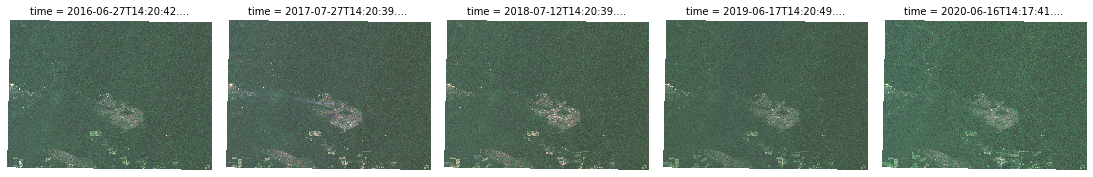

In [12]:
true_color_aggs = [
    ms.true_color(
        x.sel(band='red'),
        x.sel(band='green'),
        x.sel(band='blue')
    ) for x in data
]

true_color = xr.concat(true_color_aggs, dim="time")
true_color.coords['time'] = data.coords['time']

show_images(true_color, cmap=None)

### NDVI

NDVI for annual data can be calculated with `xarray-spatial` as below.

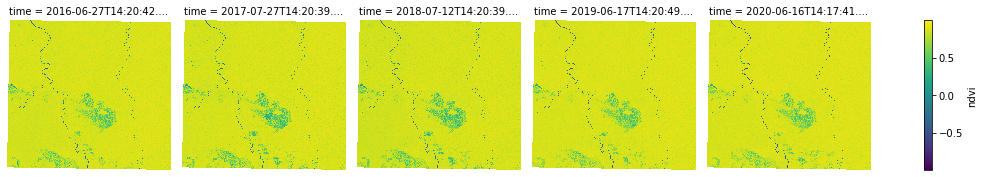

In [13]:
ndvi_aggs = [
    ms.ndvi(
        x.sel(band='nir'), x.sel(band='red')
    ) for x in data
]

ndvi = xr.concat(ndvi_aggs, dim="time")

show_images(ndvi)

### Hotspots

To identify hot and cold spots in a data aggregate, we need to provide a kernel, which is a numpy ndarray, along with the input data array to be analysed. 

In [14]:
cellsize = calc_cellsize(data)
cellsize

/srv/conda/envs/notebook/lib/python3.8/site-packages/xrspatial/convolution.py:168: Warning: Raster distance unit not provided. Use meter as default.
  warnings.warn('Raster distance unit not provided. '


(100.0, 100.0)

In this example, each pixel represents a region of `100m x 100m`, let's consider a circular kernel with a radius of 1.5km, equivalent to 15 times of the input cellsize.

In [15]:
kernel = circle_kernel(*cellsize, radius=15*cellsize[0])

kernel.shape

/srv/conda/envs/notebook/lib/python3.8/site-packages/xrspatial/convolution.py:58: Warning: Raster distance unit not provided. Use meter as default.
  warnings.warn('Raster distance unit not provided. '


(31, 31)

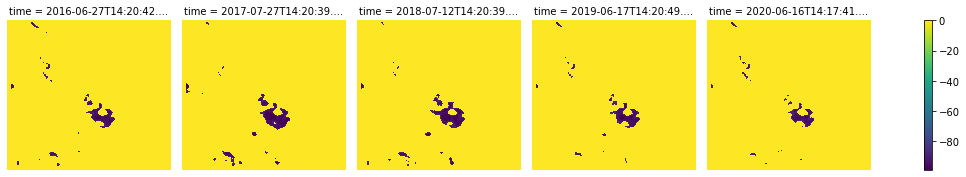

In [16]:
hotspots_aggs = [
    hotspots(ndvi_agg, kernel) for ndvi_agg in ndvi_aggs
]
hotspots_ndvi = xr.concat(hotspots_aggs, dim="time")

show_images(hotspots_ndvi)

In [17]:
np.unique(hotspots_ndvi)

array([-99, -95, -90,   0], dtype=int8)

There are 7 possible value for a pixel of the results of `hotspots` function

- +90 for 90% confidence high value cluster (hot spot)
- +95 for 95% confidence high value cluster
- +99 for 99% confidence high value cluster
- -90 for 90% confidence low value cluster (cold spot)
- -95 for 95% confidence low value cluster
- -99 for 99% confidence low value cluster
- 0 for no significance

Looking into the results above, we can see that there only cold spots detected for this region. They grow mostly in 2017, 2018 and has been gradually reduced in 2020.